# 207 Final Project: How Old Are You??

## Section 99: Matt Wong, Irene Ju, Wesley Kwong

The goal of this project is the predict age using deep learning on image data. Our general plan (so far) is to use a CNN to either do all the prediction or to use an ensemble method with the CNN, other features in the dataset (like ethnicity), and extracted facial features (like distance between nose and mouth).

In [79]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import io
from sklearn.model_selection import train_test_split
#from google.colab import files

In [80]:
# Code to run files from google.colab
# uploaded = files.upload()
# !mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
#
# !kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv
# !mkdir age_gender
# ! unzip age-gender-and-ethnicity-face-data-csv.zip -d age_gender

In [81]:
data = pd.read_csv('age_gender.csv')
ethnic_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Hispanic"}

# Ethnicity and gender is a number so we added a column for a string label
data["ethnicity_str"] = [ethnic_dict[x] for x in data["ethnicity"]]
data["gender_str"] =["Male" if x ==0 else "Female" for x in data["gender"]]
data.head()

ImportError: cannot import name 'OrderedDict' from 'pandas.compat' (/opt/venv/lib/python3.7/site-packages/pandas/compat/__init__.py)

   age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels ethnicity_str gender_str  
0  129 128 128 126 127 130 133 135 139 142 145 14...         Asian       Male  
1  164 74 111 168 169 171 175 182 184 188 193 199...         Asian       Male  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...         Asian       Male  
3  193 197 198 200 199 200 202 203 204 205 208 21...         Asian       Male  
4  202 205 209 210 209 209 210 211 212 214 218 21...         Asian       Male  

## EDA

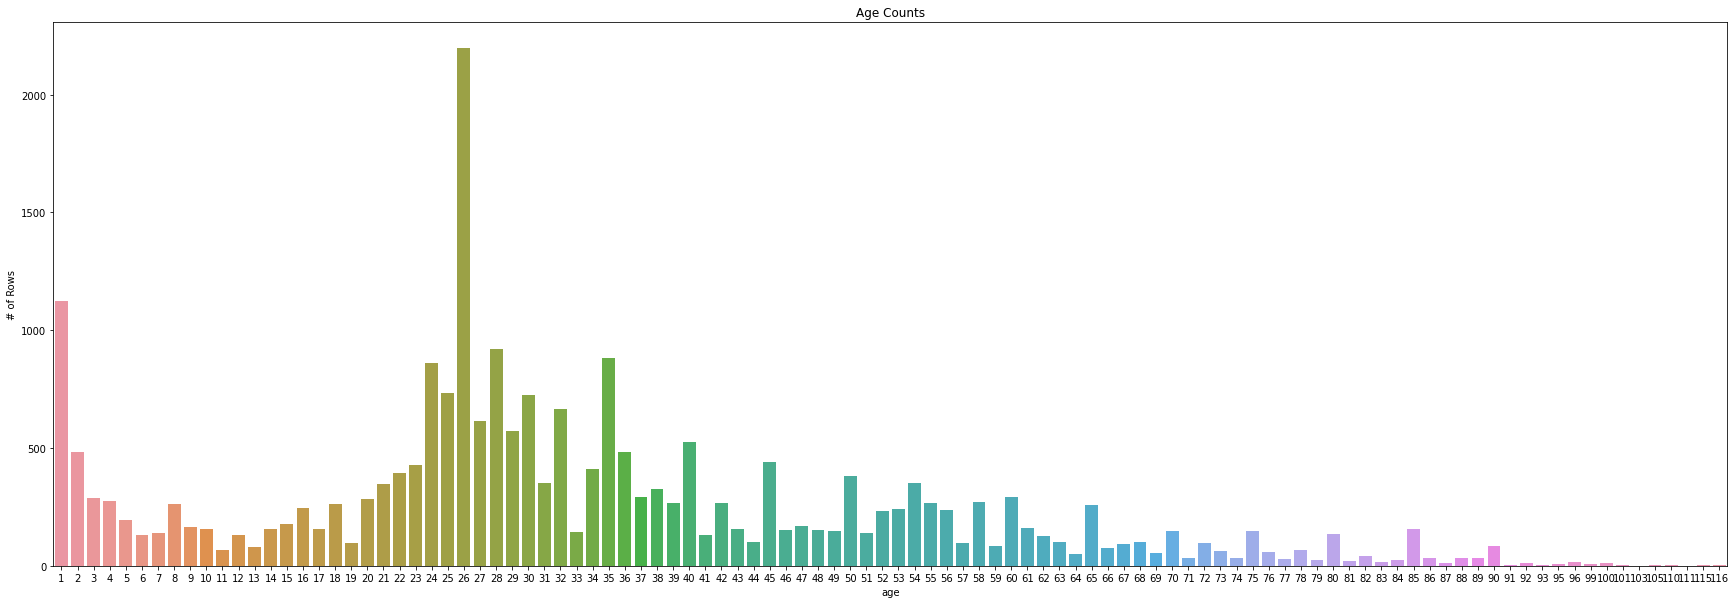

In [82]:
age_counts = data.groupby("age")["img_name"].count()
fig,ax = plt.subplots(figsize=(30,10))
ax = sns.barplot(x=age_counts.index,y=age_counts)
ax.set_title("Age Counts")
ax.set_ylabel("# of Rows");

In [83]:
min(data['age']), max(data['age'])

(1, 116)

The distribution of ages is somewhat normal with a large spike at 26. The minimum age is 1 and the maximum age is 116. Since there is such a huge range, we decided that we would do a prediction based on an age range of every 5 years. So pictures with ages 1-5 would fall into the same age bin.

In [84]:
age_bins = np.arange(0, np.max(data['age'])+5, 5)
age_bins

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120])

In [85]:
data['age_binned'] = np.digitize(data['age'], age_bins)
np.unique(data['age_binned'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

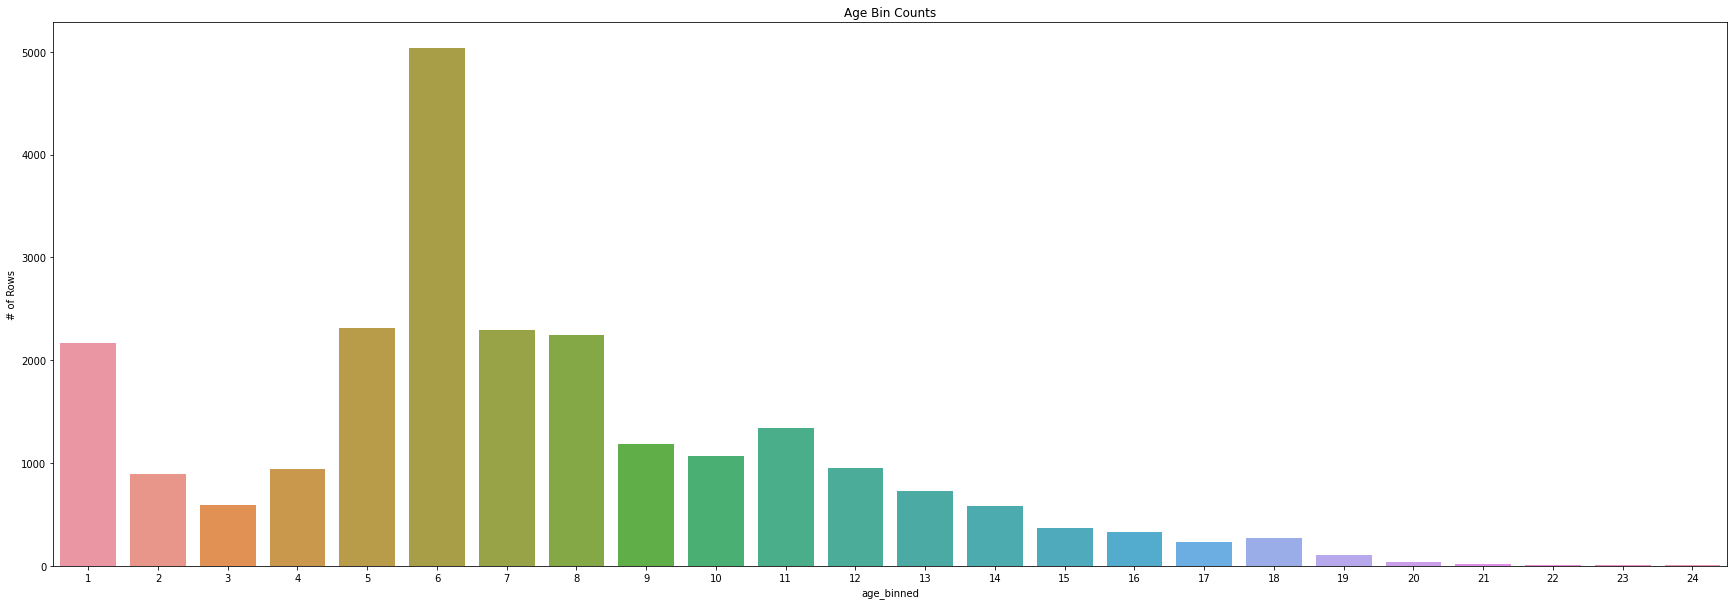

In [86]:
age_counts = data.groupby("age_binned")["age_binned"].count()
fig,ax = plt.subplots(figsize=(30,10))
ax = sns.barplot(x=age_counts.index,y=age_counts)
ax.set_title("Age Bin Counts")
ax.set_ylabel("# of Rows");

After binning, we can see that the distribution roughly follows the age distribution without the binning. However, we can see that the range of possible values goes from 1 to 24 instead of 1 to 116. This will be easier to train our model.

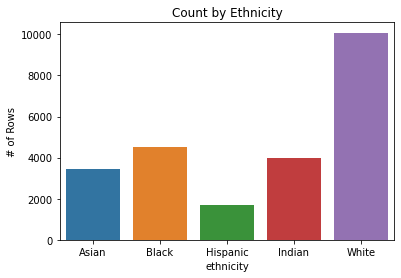

In [87]:
by_ethnicity= data.groupby("ethnicity_str")["img_name"].count()
sns.barplot(x=by_ethnicity.index,y=by_ethnicity);
plt.title("Count by Ethnicity")
plt.xlabel("ethnicity")
plt.ylabel("# of Rows");

Our data contains a lot of people who consider their ethnicity to be white, which shows that there is a lot of bias in our existing dataset. We may want to try implementing a stratified random sample method to ensure there is an equal number of pictures based on ethnicity.

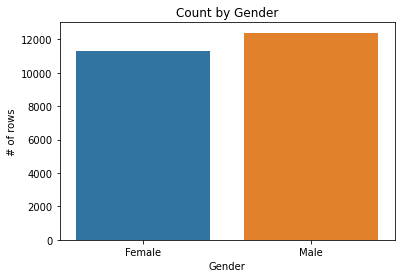

In [88]:
gender_counts = data.groupby("gender_str")["img_name"].count()
sns.barplot(x=gender_counts.index,y=gender_counts)
plt.title("Count by Gender")
plt.xlabel("Gender")
plt.ylabel("# of rows");

There are more labelled males than labelled females in the dataset but its pretty balanced.

In [89]:
data["img_name"].head()

0    20161219203650636.jpg.chip.jpg
1    20161219222752047.jpg.chip.jpg
2    20161219222832191.jpg.chip.jpg
3    20161220144911423.jpg.chip.jpg
4    20161220144914327.jpg.chip.jpg
Name: img_name, dtype: object

The img_name column has a bunch of names of the pictures. Otherwise, it isn't very informational.

## Preprocess Pixel Strings to Images

In [90]:
# Convert string of pixel values into a long numpy array
X = data['pixels'].apply(lambda x:  np.array(x.split(" "), dtype="float32")) 

In [92]:
# Converting pixels from 1D to 3D
# (num_examples, pixel_dim, pixel_dim, color_layer)
# Color layer is 1 since its grayscale, 3 for RGB
# Keras needs the 1 to know number of layers
X = np.stack(np.array(X), axis=0)
X = np.reshape(X, (-1, 48, 48, 1))

# Pixel value normalization
# RGB values are from 0 to 255
if np.max(X) > 1: X = X / 255

# Why -1:
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape

In [93]:
X.shape

(23705, 48, 48, 1)

After processing, we can see that the string of pixels can form a 48 x 48 picture. The 1 on the right shows that there is only 1 filter (ie the picture is grayscale).

Lets plot some images below:

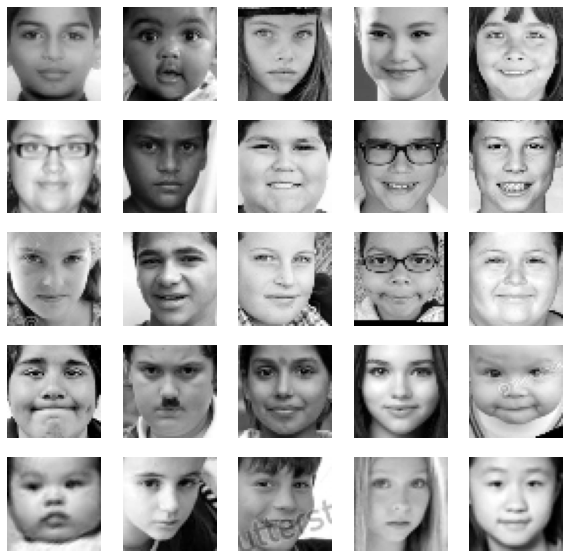

In [94]:
plt.figure(figsize=(10, 10))

for index, image in enumerate(np.random.randint(1000, 2000, 25)):
    plt.subplot(5, 5, index + 1)
    plt.imshow(X[image], cmap='gray')
    plt.axis('off')

plt.show()

## Basic ML Model

We will run a basic multinomial naive bayes ML model that takes in the photo data and output the predicted age range.

In [95]:
X = data['pixels'].apply(lambda x:  np.array(x.split(" "), dtype="float32"))
X = np.stack(np.array(X), axis=0)
X = np.reshape(X, (-1, 2304))
y = data["age_binned"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print('Number of rows:', data.shape[0])
print('Number of training rows:', X_train.shape[0])
print('Number of dev rows:', X_dev.shape[0])
print('Number of test rows:', X_test.shape[0])

Number of rows: 23705
Number of training rows: 17067
Number of dev rows: 1897
Number of test rows: 4741


In [96]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [98]:
print('Train Accuracy:', model.score(X_train, y_train, sample_weight=None)*100)
print('Dev Accuracy:', model.score(X_dev, y_dev, sample_weight=None)*100)

Train Accuracy: 14.525106931505244
Dev Accuracy: 14.496573537163943


The metric of evaluation that we are using is accuracy. We want to have the model correctly predict the age bin. Other evaluation measures such as mean squared error is not used here because the age bin variable is a nominal variable.

Our basic ML model shows very poor performance. This makes sense given that the pixel values do not form a linear relationship and much of the location data is lost when we compress a 2D array into a 1D array. However, we don't see any overfitting given that the training and dev accuracy are similar.